## Import Dependencies 

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import sys

from src.utils.construct_positional_indexes import construct_positional_indexes
from src.utils.load_index import load_index
from src.models.TextPreprocessor import PersianTextPreprocessor
from src.enums import *

In [3]:
manager = construct_positional_indexes()
manager.save_index("manager.pickle")

100%|██████████| 1572/1572 [00:09<00:00, 161.49it/s]


In [5]:
text_preprocessor = PersianTextPreprocessor()
manager = load_index("manager.pickle", text_preprocessor)

In [6]:
manager.corpus_index.get_posting_list("با")[0].get_positions(Fields.TEXT)

[278, 313, 330, 477]

In [7]:
word = "آقو"

In [8]:
manager.correct_word(word)

'آقوس'

In [9]:
manager.search("نیمه شعبان")

[5619,
 3666,
 5236,
 6208,
 7123,
 6177,
 3665,
 6791,
 3360,
 6475,
 4438,
 7101,
 6626,
 6548,
 4335]

In [10]:
manager.search("نیمه شعبان")

[5619,
 3666,
 5236,
 6208,
 7123,
 6177,
 3665,
 6791,
 3360,
 6475,
 4438,
 7101,
 6626,
 6548,
 4335]

In [5]:
manager.search("نیمه شعبان")

[5619,
 3666,
 5236,
 6208,
 7123,
 6177,
 3665,
 6791,
 3360,
 6475,
 4438,
 7101,
 6626,
 6548,
 4335]

In [14]:
manager.add_document_to_indexes("./data/Add.xml", 7157)

In [11]:
manager.search({Fields.TITLE: '"آقا علیرضا"'})

[7157]

In [12]:
manager.delete_document_from_indexes("./data/Add.xml", 7157)

In [15]:
print(manager.corpus_index.index["آقا"].posting_list[-1])


        Document ID: 7157
        Title Positions: [0]
        Text Positions: [0]
        


In [16]:
manager.corpus_index.index["آقا"].doc_frequency

{<Fields.TEXT: 'text'>: 62, <Fields.TITLE: 'title'>: 1}

In [17]:
from src.metrics import (
    f_measure,
    precision,
    r_precision,
    recall,
    ndcg_at_k,
    average_precision,
    evaluate_search_engine,
)

In [22]:
evaluate_search_engine(manager, Methods.LTN_LNN)

r_precision: 0.6105804602529432
ndcg: 0.6787020126128037
f_measure: 0.6279770638289564
map: 0.7569273771354816


In [ ]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [25]:
import time

from typing import Optional, List

from src.enums import Fields
from src.models.Document import Document
from src.types import DocID
from src.utils.read_document import read_documents_json
from src.models.TextPreprocessor import PersianTextPreprocessor, EnglishTextPreprocessor
from src.models.Manager import Manager

import numpy as np
from collections import Counter
from tqdm import tqdm

In [26]:
text_preprocessor = EnglishTextPreprocessor(lemmatize=True)

In [27]:
train_documents = read_documents_json('./MIR_Phase2/data/train.json', text_preprocessor)
val_documents = read_documents_json('./MIR_Phase2/data/validation.json', text_preprocessor)

In [28]:
manager = Manager(train_documents, [Fields.BODY, Fields.TITLE], text_preprocessor)

100%|██████████| 24000/24000 [00:06<00:00, 3711.52it/s]


In [29]:
def cosine_normalize(mat: np.ndarray):
    return mat / np.linalg.norm(mat, axis=1)[:, np.newaxis]

In [30]:
fields = manager.fields
num_tokens = len(manager.corpus_index.index)
num_train_docs = len(manager.documents)
num_val_docs = len(val_documents)

In [31]:
train_matrix = np.zeros((num_train_docs, num_tokens), dtype=np.float32)
val_matrix = np.zeros((num_val_docs, num_tokens), dtype=np.float32)

In [32]:
for index, (token, token_item) in tqdm(enumerate(manager.corpus_index.index.items()), total=num_tokens):
    for field in fields:
        df = token_item.doc_frequency[field]
        if df == 0:
            continue
        idf = np.log10(num_train_docs/df)
        for posting_list_item in token_item.posting_list:
            doc_id = posting_list_item.doc_id
            tf = posting_list_item.get_tf(field)
            train_matrix[doc_id, index] += tf * idf

100%|██████████| 26952/26952 [00:05<00:00, 4748.31it/s] 


In [11]:
normalized_train_matrix = cosine_normalize(train_matrix)

In [33]:
val_documents_counts = {}
for field in fields:
    val_documents_counts[field] = []
    for doc in val_documents:
        val_documents_counts[field].append(Counter(doc.get_tokens(field)))

In [34]:
for token_index, (token, token_item) in tqdm(enumerate(manager.corpus_index.index.items()), total=num_tokens):
    for field in fields:
        df = token_item.doc_frequency[field]
        if df == 0:
            continue
        idf = np.log10(num_train_docs/df)
        for doc_index, count in enumerate(val_documents_counts[field]):
            if token in count:
                val_matrix[doc_index, token_index] += idf * count[token]

100%|██████████| 26952/26952 [00:20<00:00, 1331.96it/s]


In [14]:
normalized_val_matrix = cosine_normalize(val_matrix)

In [20]:
import numba as nb
from numba import njit

@njit(nb.float32[:,:](nb.float32[:,:], nb.float32[:,:]), fastmath=True)
def calc_similarities(normalized_train_matrix, normalized_val_matrix):
    sims = np.dot(normalized_train_matrix, normalized_val_matrix.T)
    return sims

<ipython-input-20-b66a48952c5c>:6: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  sims = np.dot(normalized_train_matrix, normalized_val_matrix.T)


In [21]:
@njit(nb.float32[:,:](nb.float32[:,:], nb.float32[:,:]), fastmath=True, parallel=True)
def calc_euclidean_distance(train_matrix, val_matrix):
    distances = np.zeros((train_matrix.shape[0], val_matrix.shape[0]), dtype=np.float32)
    for i in range(val_matrix.shape[0]):
        doc_vector = val_matrix[i, :]
        distances[:, i] = np.sum(np.square(train_matrix - doc_vector), axis=1)
    return distances

In [20]:
res = calc_similarities(normalized_train_matrix, normalized_val_matrix)

In [ ]:
start = time.time()
distances = calc_euclidean_distance(train_matrix, val_matrix)
end = time.time()
print(end - start)

In [22]:
x = np.argmax(res, axis=0)

In [24]:
x[0]

13659

In [62]:
documents[13659].category

4

In [18]:
distances = np.zeros((train_matrix.shape[0], val_matrix.shape[0]), dtype=np.float32)
for i in range(val_matrix.shape[0]):
    doc_vector = val_matrix[i, :]
    distances[:, i] = np.sum(np.square(train_matrix - doc_vector), axis=1)
    break

In [19]:
np.sum(np.square(train_matrix - doc_vector), axis=1).shape

(24000,)

In [ ]:
((train_matrix - doc_vector) @ (train_matrix - doc_vector).T).shape

In [13]:
doc_vector = val_matrix[1:3, :]

In [14]:
doc_vector.shape

(2, 27047)

In [16]:
(np.square(train_matrix[:,np.newaxis]-val_matrix).sum(axis=2)).shape

MemoryError: Unable to allocate array with shape (24000, 3000, 27047) and data type float32

In [17]:
val_matrix.shape

(3000, 27047)

In [17]:
doc_vector.shape

(27047,)

In [27]:
np.linalg.norm(train_matrix - doc_vector, axis=1).shape

(24000,)

In [20]:
distances[:, i].shape

(24000,)

In [21]:
(train_matrix - doc_vector).shape

(24000, 27047)

In [29]:
np.sum(np.square(train_matrix - doc_vector), axis=1).shape

(24000,)

In [12]:
from src.models.NaiveBayes import NaiveBayes

In [13]:
smoothing = 1
num_classes = 4
classifier = NaiveBayes(manager, smoothing, num_classes)

In [14]:
classifier.train()

In [15]:
classifier.test(val_documents)

array([4, 1, 4, ..., 1, 1, 1])

## SVC 

In [16]:
from sklearn.svm import SVC

In [17]:
clf = SVC()

In [26]:
y_train = list(map(lambda doc: doc.category, manager.documents.values()))

In [ ]:
clf.fit(train_matrix, y_train)

/home/alireza/anaconda3/envs/skyrim/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## K-Means

In [60]:
import time

from src.ml import k_means

In [61]:
num_iterations = 1
num_centers = 4
initial_centroids = train_matrix[np.random.randint(0, num_train_docs, size=num_centers)]

In [62]:
t1 = time.time()
x = kmeans(train_matrix, initial_centroids, num_centers, num_iterations)
t = time.time()-t1
print("SELFTIMED:", t)

SELFTIMED: 3.413062572479248


## TSNE

In [63]:
from sklearn.manifold import TSNE

In [71]:
chosen_documents = []

for index in range(num_train_docs):
    if index % 100 == 0:
        chosen_documents.append(train_matrix[index])

In [66]:
tsne = TSNE()

In [73]:
chosen_documents = np.array(chosen_documents)

In [74]:
chosen_documents.shape

(240, 26952)

In [76]:
X_embedded = tsne.fit_transform(chosen_documents)

In [77]:
X_embedded.shape

(240, 2)

In [78]:
import matplotlib.pyplot as plt

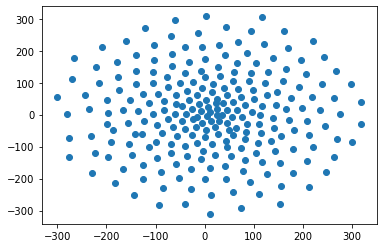

In [80]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])